# Project Overview


## 0) Package installs + imports



In [ ]:
## mount Google drive (optional, recommended)
## DEBUG TIP ##
## when restarting session, be sure to run first two lines (else you can comment out)
from google.colab import drive
drive.mount('/content/drive')

# !mkdir -p /content/drive/MyDrive/bioe_190_290/
# !mkdir -p /content/drive/MyDrive/bioe_190_290/pythonpkg/
# !mkdir -p /content/drive/MyDrive/bioe_190_290/project/

## set working dir (feel free to change)
%cd /content/drive/MyDrive/bioe_190_290/project/

Mounted at /content/drive
/content/drive/MyDrive/bioe_190_290/project


In [ ]:
%%capture

pkg_contents = !ls /content/drive/MyDrive/bioe_190_290/pythonpkg/
# do_install = len(pkg_contents) < 10 

## this umap dependency has to be reinstalled each time (it's quick!)
!pip install pynndescent 

# if do_install:
!pip install --target=/content/drive/MyDrive/bioe_190_290/pythonpkg/ scprep 
!pip install --target=/content/drive/MyDrive/bioe_190_290/pythonpkg/ umap-learn magic-impute louvain
!pip install --target=/content/drive/MyDrive/bioe_190_290/pythonpkg/ scanpy
!pip install --target=/content/drive/MyDrive/bioe_190_290/pythonpkg/ anndata
!pip install --target=/content/drive/MyDrive/bioe_190_290/pythonpkg/ scipy
!pip install --target=/content/drive/MyDrive/bioe_190_290/pythonpkg/ pandas
!pip install --target=/content/drive/MyDrive/bioe_190_290/pythonpkg/ umap
!pip install --target=/content/drive/MyDrive/bioe_190_290/pythonpkg/ leidenalg
!pip install --target=/content/drive/MyDrive/bioe_190_290/pythonpkg/ random
!pip install --target=/content/drive/MyDrive/bioe_190_290/pythonpkg/ git+https://github.com/dpeerlab/phenograph.git
!pip install --target=/content/drive/MyDrive/bioe_190_290/pythonpkg/ datetime
!pip install --target=/content/drive/MyDrive/bioe_190_290/pythonpkg/ tasklogger
!pip install --target=/content/drive/MyDrive/bioe_190_290/pythonpkg/ sklearn

!chmod 700 /content/drive/MyDrive/bioe_190_290/pythonpkg/phenograph/louvain/*

## this is IMPORTANT -- otherwise python won't be able to find 
import sys
if sys.path[0] != '/content/drive/MyDrive/bioe_190_290/pythonpkg/':
  sys.path.insert(0, '/content/drive/MyDrive/bioe_190_290/pythonpkg/')

In [ ]:
import pandas as pd
import tasklogger
import sklearn
import sklearn.cluster
import sklearn.manifold
import numpy as np
import scprep 
import phenograph
import random
import matplotlib.pyplot as plt
import scanpy as sc
import scipy
import umap
import leidenalg
from datetime import datetime
%matplotlib inline 

## 1) Import dataset


Download dataset at: https://www.tissueimmunecellatlas.org/
Download Raw for B cell compartment

In [ ]:
dataset = sc.read("/content/drive/MyDrive/bioe_190_290/project/CountAdded_PIP_B_object_for_cellxgene.h5ad")

In [ ]:
# Method 2: Get a random sample from the 54934 cells
random_rows = random.sample(range(0, 54933), 15000)
selected_rows = dataset.obs.index[random_rows].tolist()


In [ ]:
my_file = open("/content/drive/MyDrive/bioe_190_290/project/16122022_04:01:53.txt", "r")
content = my_file.read()
content = content[2:(len(content) -2)]
content = content.split("', '")
selected_rows = content

In [ ]:
# Visualize cell metadata
dataset.obs.head()

,Organ,Donor,Chemistry,Predicted_labels_CellTypist,Majority_voting_CellTypist,Manually_curated_celltype,Sex,Age_range
Pan_T7935490_AGGGAGTAGTACGCGA,ILE,A29,5v1,Memory B cells,Memory B cells,Memory B cells,Female,65-70
Pan_T7935490_ATTCTACGTAAGGGAA,ILE,A29,5v1,Naive B cells,Naive B cells,Naive B cells,Female,65-70
Pan_T7935490_ATTGGTGGTCTAAAGA,ILE,A29,5v1,Plasma cells,Plasma cells,Plasma cells,Female,65-70
Pan_T7935490_CCGGGATCAGCTTAAC,ILE,A29,5v1,Plasma cells,Plasma cells,Plasma cells,Female,65-70
Pan_T7935490_CCTTCGAGTCAGAAGC,ILE,A29,5v1,Plasma cells,Plasma cells,Plasma cells,Female,65-70


In [ ]:
# Visualize gene metadata
dataset.var.head()

""
MIR1302-2HG
FAM138A
OR4F5
AL627309.1
AL627309.3


In [ ]:
# Save matrix
matrix = scipy.sparse.csr_matrix.toarray(dataset.X)
#(54934, 36601)
# cells, genes

In [ ]:
print(dataset)

AnnData object with n_obs × n_vars = 54934 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'Sex', 'Age_range'
    uns: 'Age_range_colors', 'Sex_colors'
    obsm: 'X_umap'
    layers: 'counts'


In [ ]:
data = pd.DataFrame(matrix, index = dataset.obs.index.values, columns=dataset.var.index.values)
data = data.loc[selected_rows]
metadata = dataset.obs.loc[selected_rows]
print(data.shape)

(15000, 36601)


In [ ]:
now = datetime.now()
dt_string = now.strftime("%d%m%Y_%H:%M:%S")
with open(f"/content/drive/MyDrive/bioe_190_290/project/{dt_string}.txt", "w") as f:
    f.write(str(selected_rows))

## 2) Filter datasets

### Filter rare genes

/content/drive/MyDrive/bioe_190_290/pythonpkg/scprep/plot/histogram.py:167: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  ax.set_xscale("symlog", linthresh=abs_min)


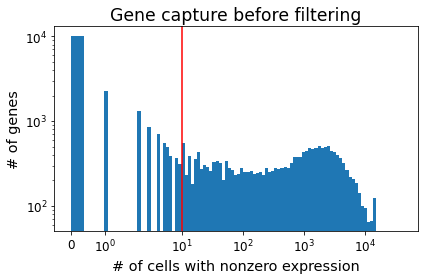

In [ ]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data), 
                      cutoff = 10,
                      log=True,
                      title="Gene capture before filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')

In [ ]:
print(data.shape)

(15000, 36601)


Filter Rare Genes


/content/drive/MyDrive/bioe_190_290/pythonpkg/scprep/plot/histogram.py:167: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  ax.set_xscale("symlog", linthresh=abs_min)


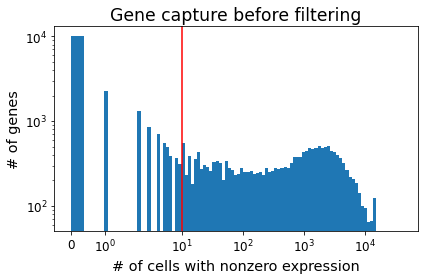

In [ ]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data), 
                      cutoff = 10,
                      log=True,
                      title="Gene capture before filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')

cutoff = 10 
data = scprep.filter.filter_rare_genes(data, min_cells=cutoff)

/content/drive/MyDrive/bioe_190_290/pythonpkg/scprep/plot/histogram.py:167: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  ax.set_xscale("symlog", linthresh=abs_min)


(15000, 19205)


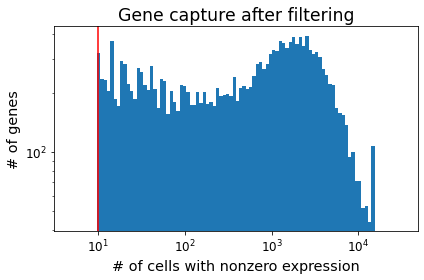

In [ ]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data), cutoff=cutoff, log=True,
                      title="Gene capture after filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')

print(data.shape)

## 3) Visualization with PCA and UMAP

### PCA Analysis

In [ ]:
data_pca = scprep.reduce.pca(data, n_components=50, method='dense')

In [ ]:
data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
CZINY-0099_ACTTCGCCACTAGAGG,18.049519,7.714269,4.563565,-5.845009,-3.727530,-1.511161,1.265706,-0.285463,-6.006965,-1.045979,...,-0.713568,0.279219,-1.114023,1.264071,0.207187,0.821510,-0.083081,-0.050519,1.196431,0.532469
CZINY-0104_CTCGAGGGTCTGCAAT,17.816952,9.311161,3.410063,-5.709269,-4.510931,-0.653049,-0.540928,0.675653,-2.364393,1.530812,...,1.025021,0.633456,-0.179994,0.453810,0.245311,0.022565,0.550912,0.016822,-0.057335,0.435276
Pan_T7991588_GCTTGAAAGGCCGAAT,-3.193996,-2.281014,1.582919,5.521255,-0.597258,-3.753015,0.811009,1.322331,-0.123416,-0.224186,...,-0.116397,1.348196,-0.737177,1.115381,-0.666883,-1.260778,0.803699,-1.625605,0.388669,-1.147313
Pan_T7980364_AAGACCTTCTAACTCT,-2.694129,-0.513320,-5.258840,-0.545980,-3.519172,-4.968784,-1.077817,0.856818,-0.380085,-0.200089,...,-1.557172,1.168975,-0.631163,-0.517824,1.214471,-1.404438,-0.321393,-1.516711,0.524036,-1.142357
CZINY-0102_TTCCTAACACGTAGTT,7.371309,19.838253,13.493900,6.790660,9.104345,3.270677,3.083150,0.822497,0.344458,-0.075043,...,-1.211490,1.099332,0.658927,0.585115,-0.527606,0.432800,0.243736,-0.645484,-0.620866,1.117373


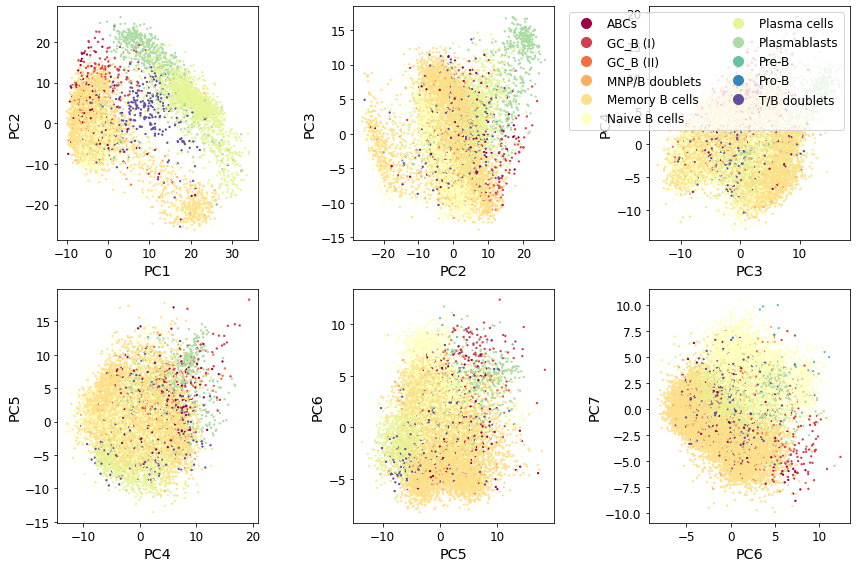

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(12,8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    legend = True if i == 2 else False
    scprep.plot.scatter(data_pca.iloc[:,i], data_pca.iloc[:,i+1], c=metadata['Manually_curated_celltype'],
                        cmap='Spectral', ax=ax,
                        xlabel = "PC" + str(i+1), ylabel = "PC" + str(i+2), legend=legend)
fig.tight_layout()

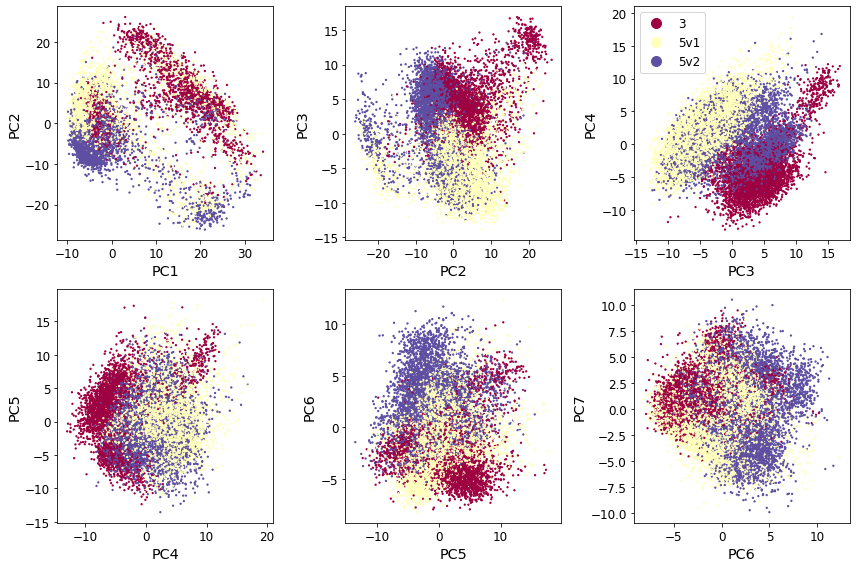

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(12,8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    legend = True if i == 2 else False
    scprep.plot.scatter(data_pca.iloc[:,i], data_pca.iloc[:,i+1], c=metadata['Chemistry'],
                        cmap='Spectral', ax=ax,
                        xlabel = "PC" + str(i+1), ylabel = "PC" + str(i+2), legend=legend)
fig.tight_layout()

UMAP

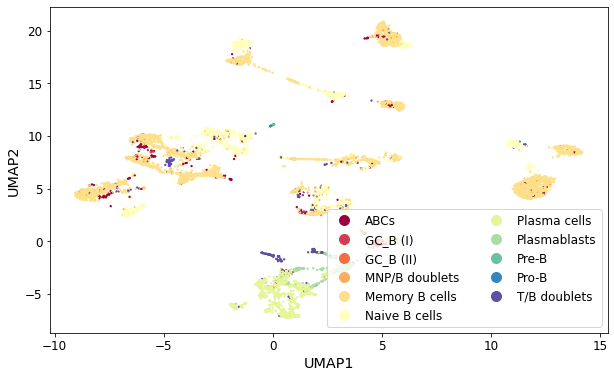

In [ ]:
data_umap = umap.UMAP().fit_transform(data_pca.iloc[:,:50])
data_umap = pd.DataFrame(data_umap, index = data.index)

fig, ax = plt.subplots(figsize=(10,6)) ## feel free to adjust size

scprep.plot.scatter2d( 
  data_umap,
  
  c=metadata['Manually_curated_celltype'], ax=ax,
  cmap='Spectral', label_prefix="UMAP"
)

Mimic UMAP Results


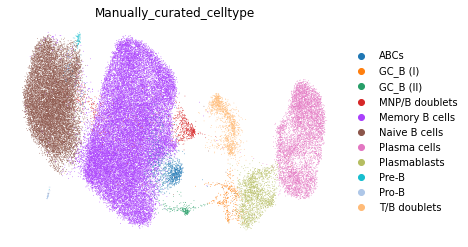

In [ ]:
sc.pl.umap(dataset, color=['Manually_curated_celltype'], frameon=False)

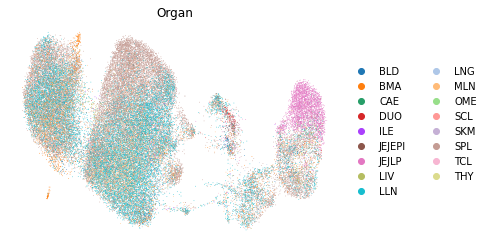

In [ ]:
sc.pl.umap(dataset, color=['Organ'], frameon=False)

## 4) Clustering

### Clustering with Louvain


In [ ]:
phenograph_clusters, _, _ = phenograph.cluster(data_pca)


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4611527919769287 seconds
Jaccard graph constructed in 3.42500901222229 seconds
Wrote graph to binary file in 0.31117963790893555 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.935954
Louvain completed 21 runs in 34.35881066322327 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 40.44915580749512 seconds


### Clustering with KMeans

In [ ]:
with tasklogger.log_task("KMeans"):
    kmeans_clusters = sklearn.cluster.KMeans(n_clusters=6).fit_predict(data_pca)

Calculating KMeans...


/content/drive/MyDrive/bioe_190_290/pythonpkg/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Calculated KMeans in 1.90 seconds.


Choosing k for KMeans algorithm

In [ ]:
%%capture

from sklearn.model_selection import train_test_split
from itertools import combinations
from scipy import sparse

def get_comemberships(dat, n_clusters, model, kwargs={}):
  ## helper function
  # returns comembership matrix and model
  model = model(n_clusters=n_clusters, **kwargs)
  model.fit(dat)

  labels = model.predict(dat)
  comember = labels_to_mat(labels, n_clusters, N=dat.shape[0])

  return comember, model

def labels_to_mat(labels, n_clusters, N):
  ## helper function
  # comembership matrix helper 

  # create and fill an NxN co-membership matrix
  comember = np.zeros((N, N), dtype=bool) 
  for i in range(n_clusters):
    match_idx = np.where(labels==i)[0]

    # slow, memory safe (we will symmetrize + add diagonal after)
    match_idx = iter(combinations(match_idx, 2))
    for (j,k) in match_idx:
      comember[j,k] = True

  # transpose here is memory bottleneck
  comember = np.maximum(comember, comember.transpose())
  comember[np.diag_indices_from(comember)] = True

  # sparsify output for storage space
  comember = sparse.csr_matrix(comember)
  return comember

def prediction_strength(full_dat, n_clusters, n_CV=3, 
                        verbose=False, model=sklearn.cluster.KMeans,
                        kwargs={}):
  ## USE THIS FUNCTION :) 
  test_size = 1./n_CV
  res = []
  for i in range(n_CV):
    train_dat, test_dat = train_test_split(full_dat, test_size=test_size)
    N_test = test_dat.shape[0]
    __, train_model  = get_comemberships(train_dat, n_clusters, model=model, kwargs=kwargs)
    ground_truth, __ = get_comemberships(test_dat, n_clusters, model=model, kwargs=kwargs)

    pred_labels      = labels_to_mat(train_model.predict(test_dat), n_clusters, N_test)

    # when match_count is N_test**2, there is no error 
    match_count      = ground_truth.minimum(pred_labels).sum()
    res.append(match_count/(N_test**2))

  if verbose:
    print(res)
  
  return np.mean(res)

pred_strengths = []
start = 2
end   = 20 
for i in range(start, end):
   pred_strengths.append(prediction_strength(data_pca, i))
new_labels = np.arange(2, 20, 1)
plt.xticks(new_labels)
plt.plot(new_labels, np.array(pred_strengths), "-y*")
plt.show()

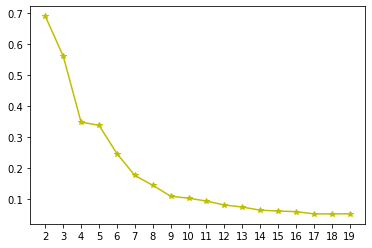

In [ ]:
new_labels = np.arange(2, 20, 1)
plt.xticks(new_labels)
plt.plot(new_labels, np.array(pred_strengths), "-y*")
plt.show()

### Comparing clusters

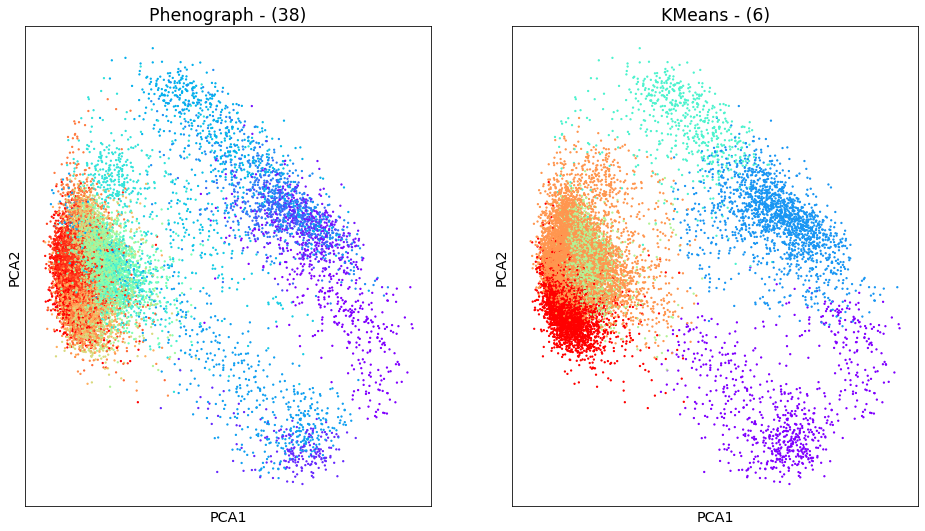

In [ ]:
clusterings = {'Phenograph':phenograph_clusters,
               'KMeans':kmeans_clusters}

for alg in clusterings:
    cl_nu = scprep.utils.sort_clusters_by_values(clusterings[alg], -data_pca.iloc[:,0])
    clusterings[alg] = cl_nu

fig, axes = plt.subplots(1,2, figsize=(16,16), subplot_kw={'aspect':'equal'})

for ax, algorithm in zip(axes.flatten(), clusterings):
  scprep.plot.scatter2d(data_pca, c=clusterings[algorithm], cmap=plt.cm.rainbow,
                        title='{} - ({})'.format(algorithm, len(np.unique(clusterings[algorithm]))), 
                        ticks=False, label_prefix="PCA", legend=False, discrete=True,
                        ax=ax)

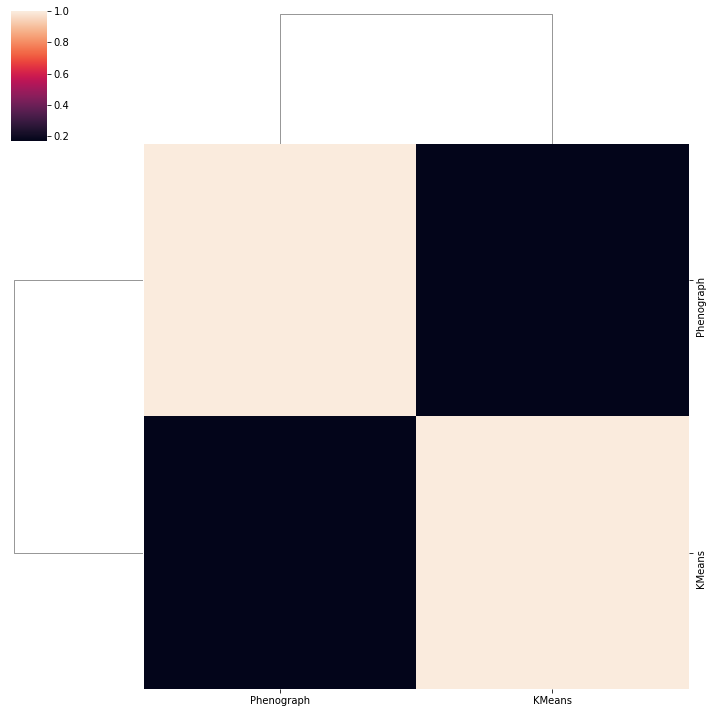

In [ ]:
all_clusterings = []
all_algorithms = list(clusterings.keys())
for algo in all_algorithms:
    all_clusterings.append(clusterings[algo])    
all_clusterings = np.vstack(all_clusterings)

from scipy.spatial.distance import pdist, squareform
cluster_similarities = squareform(pdist(all_clusterings, metric=sklearn.metrics.adjusted_rand_score))
cluster_similarities = cluster_similarities + np.eye(2)

import seaborn as sns
sns.clustermap(cluster_similarities, xticklabels=all_algorithms, yticklabels=all_algorithms)
plt.show()

## 5) Differently expressed genes - Cell type

Here is the B Cell expression heatmap that was conducted on the data:

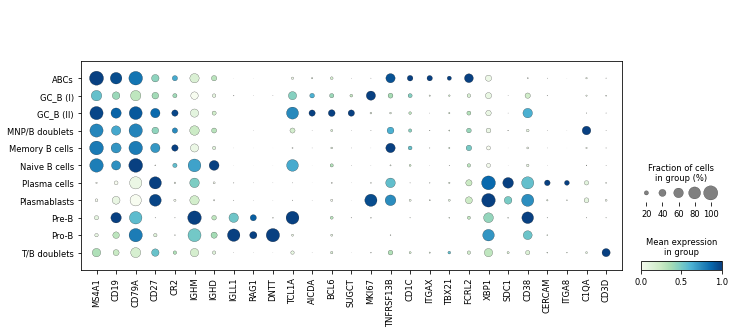

In [ ]:
sc.pl.dotplot(dataset, var_names=['MS4A1','CD19','CD79A','CD27','CR2','IGHM','IGHD','IGLL1','RAG1','DNTT','TCL1A','AICDA','BCL6','SUGCT','MKI67','TNFRSF13B','CD1C','ITGAX','TBX21','FCRL2','XBP1','SDC1','CD38','CERCAM','ITGA8','C1QA','CD3D'], groupby='Manually_curated_celltype', standard_scale='var', cmap='GnBu')

Run same analysis, but on top 5 differentially expressed genes across all groups.

In [ ]:
data_sparse = scprep.utils.SparseDataFrame(data)
with tasklogger.log_task("t-test"):
    ttest_results = scprep.stats.differential_expression_by_cluster(data, 
                                                         metadata["Manually_curated_celltype"], 
                                                         measure='ttest')
    


Calculating t-test...
Calculated t-test in 14.33 seconds.


88
71
['TCL1A', 'GAPDH', 'TNFRSF13B', 'ABCB9', 'ACTG1', 'CD44', 'CD74', 'ARHGAP24', 'CD3E', 'CD83', 'SIK3', 'GALNT3', 'IL32', 'BANK1', 'REL', 'HLA-DPB1', 'MAML2', 'SPINK2', 'TNFRSF13C', 'LTB', 'ITM2C', 'CD37', 'SELL', 'AIM2', 'IGHA1', 'HLA-DRA', 'SYNGR2', 'FYB1', 'EMP3', 'HLA-DQA1', 'AC020916.1', 'NOMO2', 'PLEKHA1', 'KLF2', 'GTPBP2', 'SHCBP1', 'CD52', 'SPOCK2', 'GPR183', 'LY9', 'SEL1L3', 'SDC1', 'BHLHE41', 'VPS37B', 'MS4A1', 'LINC01781', 'COTL1', 'LINC00926', 'IL7R', 'LYN', 'PCLAF', 'CD38', 'TMEM187', 'CD27', 'SP140', 'AL139020.1', 'AFF3', 'CD7', 'CTNNAL1', 'YBX3', 'TRIM22', 'SCAMP1-AS1', 'NT5E', 'LINC02362', 'ACTB', 'JCHAIN', 'SOCS3', 'PLPP5', 'HLA-DRB1', 'CD3D', 'ADAM28']


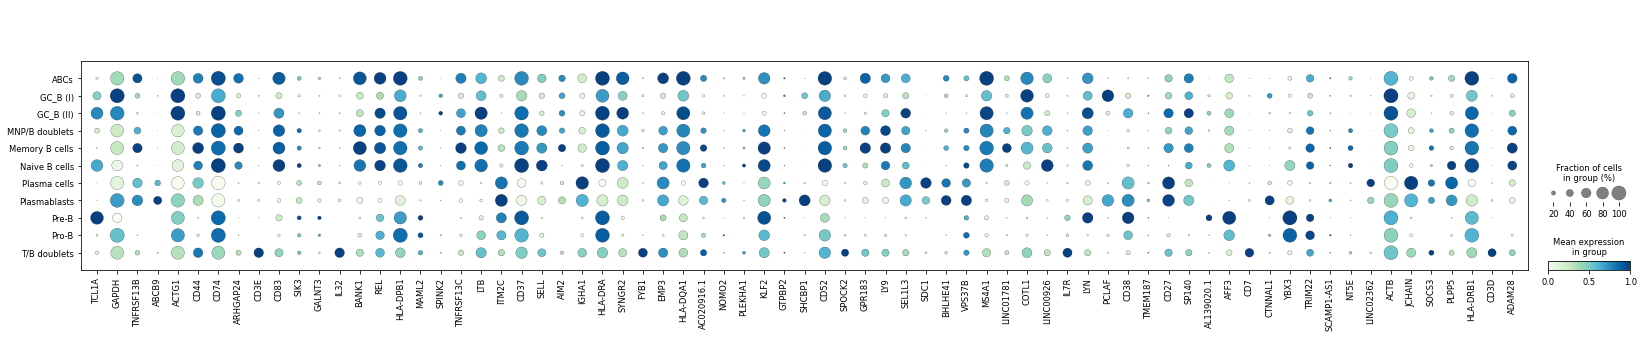

In [ ]:
# print(ttest_results.keys())

ttest_keys = ttest_results.keys()
diff_genes = []

for cell_type in ttest_keys:
  top_hits = ttest_results[cell_type].head(8).index.tolist()
  diff_genes = diff_genes + top_hits

print(len(diff_genes))
diff_genes = [*set(diff_genes)]
print(len(diff_genes))
print(diff_genes)
sc.pl.dotplot(dataset, var_names=diff_genes, groupby='Manually_curated_celltype', standard_scale='var', cmap='GnBu')

### Gene 1 - SDC1

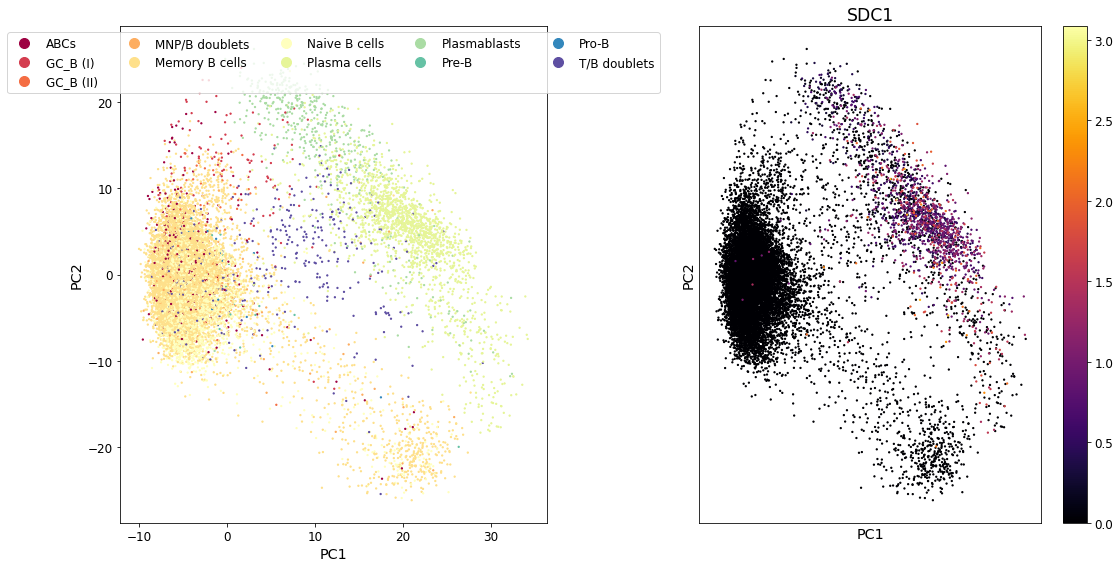

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,8))
axes = axes.flatten()

for i, ax in enumerate(axes):
  if i == 1:
    expression = scprep.select.select_cols(data, exact_word='SDC1')
    sort_index = expression.sort_values().index
    scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                        title='SDC1', ticks=None, label_prefix='PC', ax=ax)  
  else:
    legend = True 
    scprep.plot.scatter(data_pca.iloc[:,i], data_pca.iloc[:,i+1], c=metadata['Manually_curated_celltype'],
                        cmap='Spectral', ax=ax,
                        xlabel = "PC" + str(i+1), ylabel = "PC" + str(i+2), legend=legend, legend_loc = "upper center", legend_ncol=5)    
fig.tight_layout()

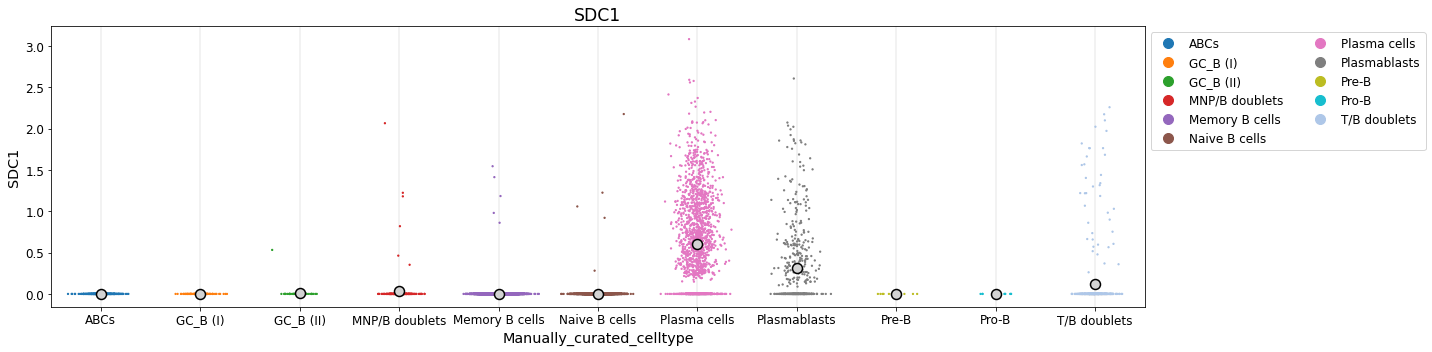

In [ ]:
curr_gene = "SDC1"
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(metadata["Manually_curated_celltype"], curr_expression, c=metadata["Manually_curated_celltype"], figsize=(20, 5),
                   legend_anchor=(1,1), title=curr_gene)

###Gene 2 - SHCBP1

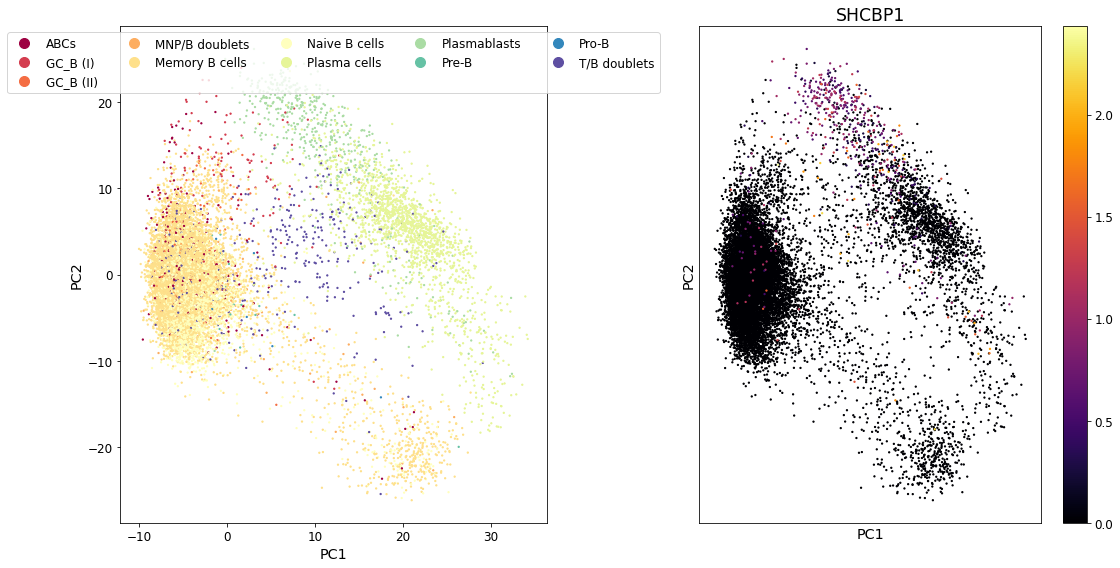

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,8))
axes = axes.flatten()

for i, ax in enumerate(axes):
  if i == 1:
    expression = scprep.select.select_cols(data, exact_word='SHCBP1')
    sort_index = expression.sort_values().index
    scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                        title='SHCBP1', ticks=None, label_prefix='PC', ax=ax)  
  else:
    legend = True 
    scprep.plot.scatter(data_pca.iloc[:,i], data_pca.iloc[:,i+1], c=metadata['Manually_curated_celltype'],
                        cmap='Spectral', ax=ax,
                        xlabel = "PC" + str(i+1), ylabel = "PC" + str(i+2), legend=legend, legend_loc = "upper center", legend_ncol=5)    
fig.tight_layout()

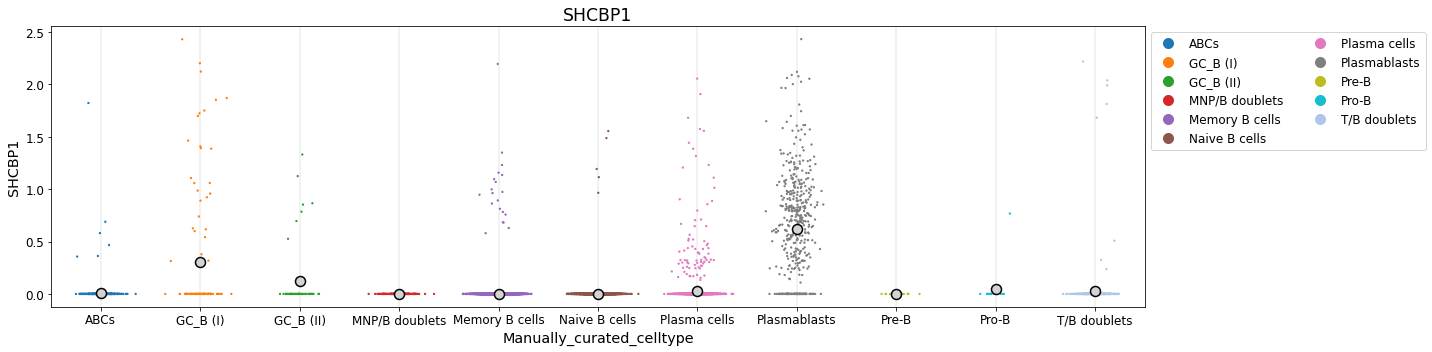

In [ ]:
curr_gene = "SHCBP1"
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(metadata["Manually_curated_celltype"], curr_expression, c=metadata["Manually_curated_celltype"], figsize=(20, 5),
                   legend_anchor=(1,1), title=curr_gene)

### Gene 3 - YBX3

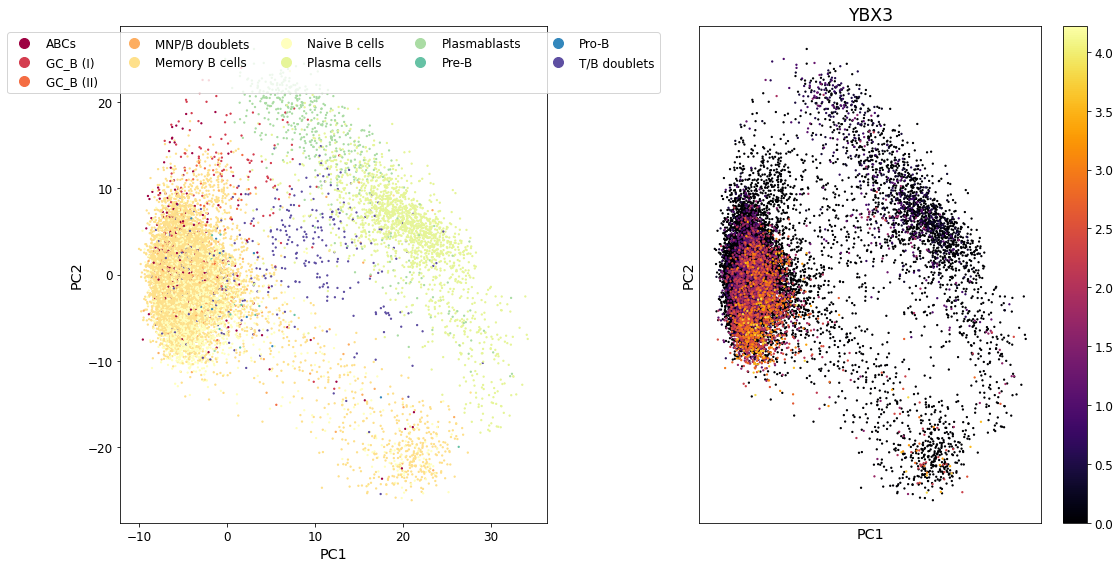

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,8))
# This makes it easier to iterate through the axes
axes = axes.flatten()

for i, ax in enumerate(axes):
  if i == 1:
    expression = scprep.select.select_cols(data, exact_word='YBX3')
    sort_index = expression.sort_values().index
    scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                        title='YBX3', ticks=None, label_prefix='PC', ax=ax)  
  else:
    legend = True 
    scprep.plot.scatter(data_pca.iloc[:,i], data_pca.iloc[:,i+1], c=metadata['Manually_curated_celltype'],
                        cmap='Spectral', ax=ax,
                        xlabel = "PC" + str(i+1), ylabel = "PC" + str(i+2), legend=legend, legend_loc = "upper center", legend_ncol=5)    
fig.tight_layout()

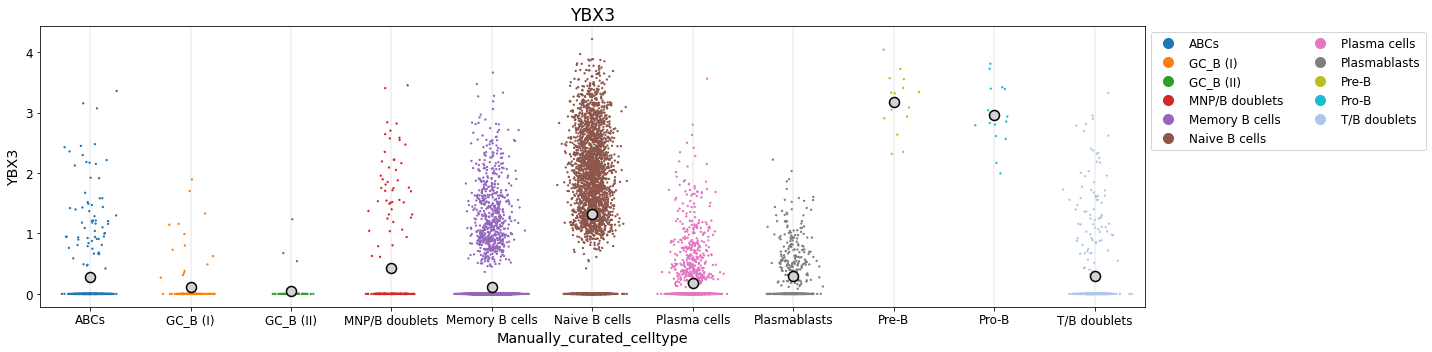

In [ ]:
curr_gene = "YBX3"
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(metadata["Manually_curated_celltype"], curr_expression, c=metadata["Manually_curated_celltype"], figsize=(20, 5),
                   legend_anchor=(1,1), title=curr_gene)

##Gene 4 - PCLAF 

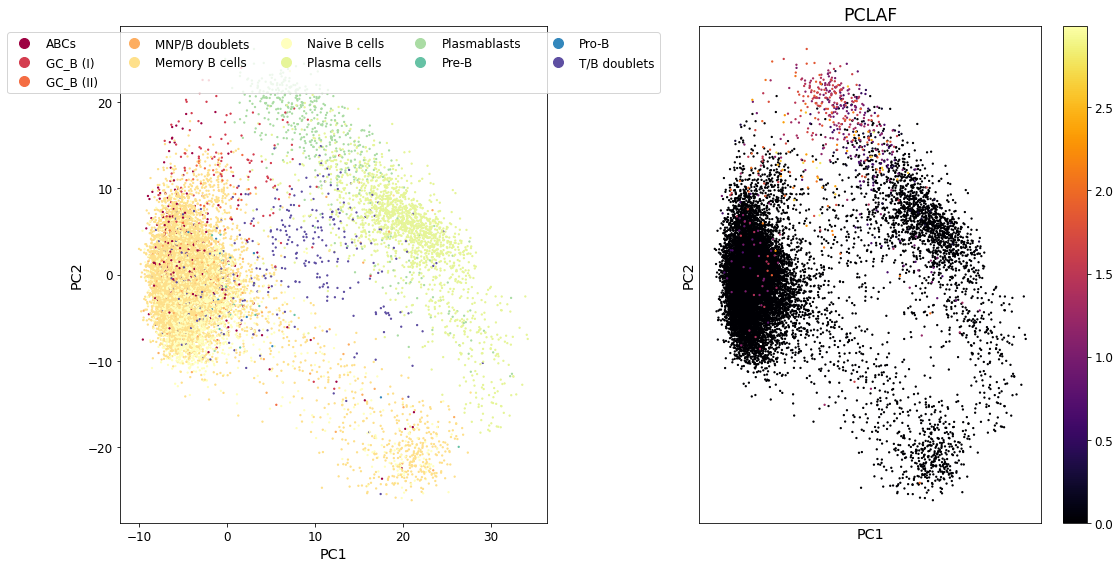

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,8))
axes = axes.flatten()

for i, ax in enumerate(axes):
  if i == 1:
    expression = scprep.select.select_cols(data, exact_word='PCLAF')
    sort_index = expression.sort_values().index
    scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                        title='PCLAF', ticks=None, label_prefix='PC', ax=ax)  
  else:
    legend = True 
    scprep.plot.scatter(data_pca.iloc[:,i], data_pca.iloc[:,i+1], c=metadata['Manually_curated_celltype'],
                        cmap='Spectral', ax=ax,
                        xlabel = "PC" + str(i+1), ylabel = "PC" + str(i+2), legend=legend, legend_loc = "upper center", legend_ncol=5)
    
fig.tight_layout()

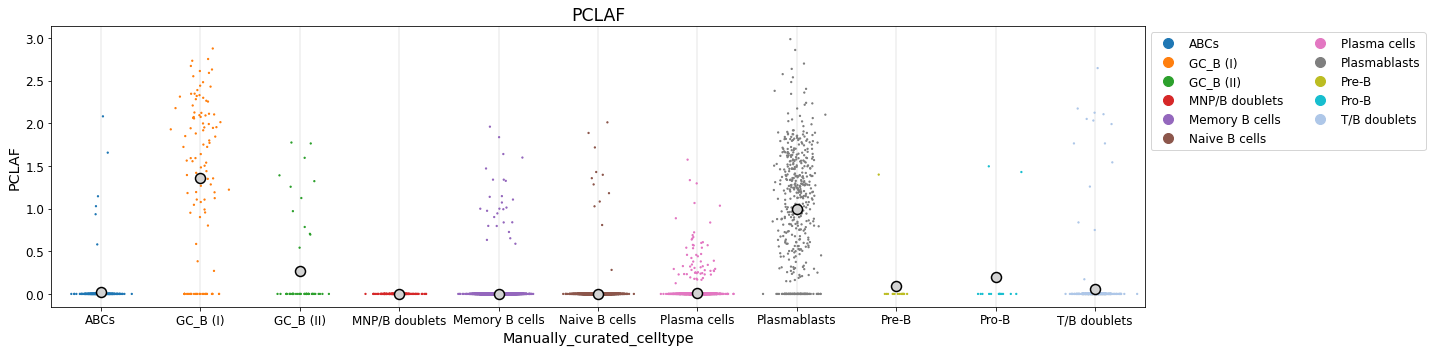

In [ ]:
curr_gene = "PCLAF"
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(metadata["Manually_curated_celltype"], curr_expression, c=metadata["Manually_curated_celltype"], figsize=(20, 5),
                   legend_anchor=(1,1), title=curr_gene)